# Tutorial: intrinsic dimension

In [8]:
import time
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dadapy import data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph

%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# import a test set
X = np.random.multivariate_normal([0, 0], [[1, 0.9999],[ 0.9999, 1]], size = (2000,))

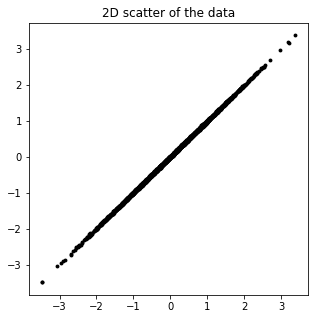

In [10]:
plt.figure(figsize = (5, 5))
plt.title('2D scatter of the data')
plt.scatter(X[:,0],X[:,1],s=15.,alpha=1.0,c='black',linewidths=0.0)
plt.show()

## TwoNN estimator

In [11]:
# initialise the Data class
_data = data.Data(X)

# estimate ID
id_twoNN, _, r_twoNN = _data.compute_id_2NN()
print(id_twoNN)

1.9994025395531865


## Scale analysis of the intrinsic dimansion: twoNN vs gride

### Data generation

In [13]:
from urllib.request import urlretrieve
from collections import namedtuple
from os.path import exists
import numpy as np

def fetch_data(data_path, data_url, force_download = True):
    if not exists(data_path) or force_download:
        print(f"downloading data from {data_url} to {data_path}")
        urlretrieve(data_url, data_path)
        dataset = np.load(data_path)
    else:
        dataset = np.load(data_path)
    return dataset

#spiral dataset
ndata = 5000
noise = 0.05
t = np.random.uniform(0,10, ndata)
spiral_data = np.array([t*np.cos(t), t*np.sin(t), t]).T + noise*np.random.rand(ndata, 3)

#mnist and isolet datasets
RemoteFileMetadata = namedtuple("RemoteFileMetadata", ["filename", "url"])
isolet = RemoteFileMetadata(filename= 'isolet_float32.npy', url='https://figshare.com/ndownloader/files/34882686')
mnist = RemoteFileMetadata(filename= 'mnist.npy', url= 'https://figshare.com/ndownloader/files/34882689')
faces = RemoteFileMetadata(filename= 'isomap_faces.npy', url= 'https://figshare.com/ndownloader/files/34894287')


faces_data = fetch_data(f'./datasets/{faces.filename}', faces.url, force_download = False)
print(f'isomap_faces shape: N data x P features = {faces_data.shape}')

isolet_data = fetch_data(f'./datasets/{isolet.filename}', isolet.url, force_download = False)
print(f'isolet shape: N data x P features = {isolet_data.shape}')

mnist_data = fetch_data(f'./datasets/{mnist.filename}', mnist.url, force_download = False)
mnist_data = mnist_data.astype('float')
print(f'mnist 1 digit shape: N data x P features = {mnist_data.shape}')


isomap_faces shape: N data x P features = (698, 4096)
downloading data from https://figshare.com/ndownloader/files/34882686 to ./datasets/isolet_float32.npy
isolet shape: N data x P features = (7797, 617)
downloading data from https://figshare.com/ndownloader/files/34882689 to ./datasets/mnist.npy
mnist 1 digit shape: N data x P features = (6742, 784)


### Data visualization

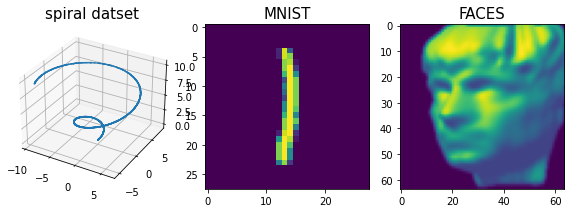

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8, 3))
gs = GridSpec(1,3)

ax = fig.add_subplot(gs[0], projection = '3d')
ax.scatter(spiral_data[:, 0], spiral_data[:, 1], spiral_data[:, 2], s = 0.1)
ax.set_title('spiral datset', fontsize = 15)

ax = fig.add_subplot(gs[1])
ax.imshow(mnist_data[10].reshape(28, 28))
ax.set_title('MNIST', fontsize = 15)

ax = fig.add_subplot(gs[2])
ax.imshow(faces_data[0].reshape(64, 64).T)
ax.set_title('FACES', fontsize = 15)

gs.tight_layout(fig)

### ID computation
###### This may take up to 20/30 seconds

In [15]:
from dadapy import data
def compute_ids_scaling(X, range_max = 2048, N_min = 20):
    "instantiate data class"
    _data = data.Data(coordinates = X, 
                     maxk = 100)
    "compute ids scaling gride"
    ids_gride, ids_err_gride, rs_gride = _data.return_id_scaling_gride(range_max=range_max)
    "compute ids with twoNN + decimation"
    ids_twoNN, ids_err_twoNN, rs_twoNN = _data.return_id_scaling_2NN(N_min = N_min)
    return ids_gride, ids_twoNN, rs_gride, rs_twoNN


"this may take from 10 to 20 seconds"
ndata_spiral = spiral_data.shape[0]
ids_spiral_gride, ids_spiral_twoNN, rs_gride, rs_twoNN = compute_ids_scaling(
                                                                            spiral_data, 
                                                                            range_max = ndata_spiral-1, 
                                                                            N_min = 4
                                                                            )

ids_mnist_gride, ids_mnist_twoNN, _, _ =  compute_ids_scaling(mnist_data, range_max = 2048, N_min = 20)
ids_faces_gride, ids_faces_twoNN, _, _ = compute_ids_scaling(faces_data, range_max = 2048, N_min = 20)
ids_isolet_gride, ids_isolet_twoNN, _, _ = compute_ids_scaling(isolet_data, range_max = 2048, N_min = 20)

### Plots

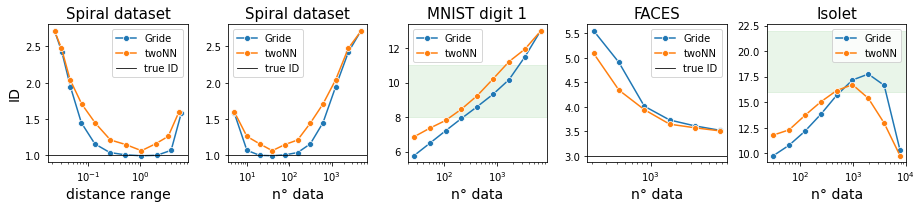

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (13, 3))
gs = GridSpec(1,5)

ax = fig.add_subplot(gs[0])
xrange = min(len(ids_spiral_gride), len(ids_spiral_twoNN))
sns.lineplot(ax = ax, x=rs_gride, y = ids_spiral_gride, label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=rs_twoNN, y = ids_spiral_twoNN, label = 'twoNN', marker = 'o')
ax.set_xscale('log')
ax.set_title('Spiral dataset', fontsize = 15)
ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('distance range', fontsize = 14)
ax.axhline(1, color = 'black', alpha = 1, label = 'true ID', linewidth = 0.8)
ax.legend(fontsize = 10)

ax = fig.add_subplot(gs[1])
xrange = min(len(ids_spiral_gride), len(ids_spiral_twoNN))
x = spiral_data.shape[0]/np.array([2**i for i in range(xrange)])
sns.lineplot(ax = ax, x=x, y = ids_spiral_gride[:xrange], label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=x, y = ids_spiral_twoNN[:xrange], label = 'twoNN', marker = 'o')
ax.legend(fontsize = 10)
ax.set_xscale('log')
ax.set_title('Spiral dataset', fontsize = 15)
#ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('n° data', fontsize = 14)
ax.axhline(1, color = 'black', alpha = 1, label = 'true ID', linewidth = 0.8)
ax.legend(fontsize = 10)

ax = fig.add_subplot(gs[2])
xrange = min(len(ids_mnist_gride), len(ids_mnist_twoNN))
x = mnist_data.shape[0]/np.array([2**i for i in range(xrange)])
sns.lineplot(ax = ax, x=x, y = ids_mnist_gride[:xrange], label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=x, y = ids_mnist_twoNN[:xrange], label = 'twoNN', marker = 'o')
ax.legend(fontsize = 10)
ax.set_xscale('log')
ax.set_title('MNIST digit 1', fontsize = 15)
#ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('n° data', fontsize = 14)
ax.axhspan(8, 11, color = 'C2', alpha = 0.1)

ax = fig.add_subplot(gs[3])
xrange = min(len(ids_faces_gride), len(ids_faces_twoNN))
x = mnist_data.shape[0]/np.array([2**i for i in range(xrange)])
sns.lineplot(ax = ax, x=x, y = ids_faces_gride[:xrange], label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=x, y = ids_faces_twoNN[:xrange], label = 'twoNN', marker = 'o')
ax.set_xscale('log')
ax.set_title('FACES', fontsize = 15)
#ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('n° data', fontsize = 14)
ax.axhline(3, color = 'black', label = 'true ID', linewidth = 0.8)
ax.legend(fontsize = 10)


ax = fig.add_subplot(gs[4])
xrange = min(len(ids_isolet_gride), len(ids_isolet_twoNN))
x = isolet_data.shape[0]/np.array([2**i for i in range(xrange)])
sns.lineplot(ax = ax, x=x, y = ids_isolet_gride[:xrange], label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=x, y = ids_isolet_twoNN[:xrange], label = 'twoNN', marker = 'o')
ax.legend(fontsize = 10)
ax.set_xscale('log')
ax.set_title('Isolet', fontsize = 15)
#ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('n° data', fontsize = 14)
ax.axhspan(16, 22, color = 'C2', alpha = 0.1)



gs.tight_layout(fig)

## Comments

#### How to plot the intrinsic dimension to analyze the scale 

##### Legend

* __ID__: list of intrinisc dimensions given at output from 'return_id_scaling_2NN'/'return_id_scaling_gride'

* __N__: total number of datapoints

* __n1__: order of the first neighbors involved in the gride estimate. They are n1 = [1, 2, 4, 8, ..., log2(range_scaling)] (n1 must have the same length of ID)

* __n_dec__ (twoNN): size of the decimated dataset. It is N/[1, 2, 4, 8, ...] up to N_min

* __rs__: average distances to the neighbors of order n1


###### Rule 1

To analyze how the ID varies with the scale we plot:
* __IDs vs N/n1__ for the __Gride__ estimator; 
* __IDs vs n_dec__ for the __twoNN__ estimator 

We typically plot the x axis in logarithmic scale.

The constant factor N in N/n1 (Gride estimator), makes the x-axis easy to compare with the twoNN estimator. Indeed, the average distances explored by Gride for n1=2 (n2=4) is comparable to that of the twoNN estimator evaluated on half of the datapoints see Fig. a.

Figures a, b show the importance of a scale analysis on the ID for a 1d spiral with 3 dimensional noise. At scales shorter than the noise standard deviation the ID is overstimated. Increasing the n1 order (Gride) or the decimation (twoNN) a plateau appears around one the 'true' ID. We also notice that when the ID is small __rule1__ (Fig. a) is equivalent to the more intuitive plot IDs vs average distance (Fig. b). 

When the ID is high (e.g. ID>5)  the concentration of measure makes all the distances comparable and __rule1__ becomes the only sensible way to go (see Figs. c, d, e). 
The ground truth ID for these datasets is not known, but there is a (debatable) consensus for the plausible range of IDs of each of them. This range is highlighted in the figures. 
The plateau for the MNIST dataset Fig. c is absent, for the face dataset is around 3.5/3.6, for the isolet dataset is around 17.6. 

When the plateau is absent we typically choose as ID the Gride estimate with n1=2, n2=4, or n1=4, n2=8, or an average of these.